<a href="https://colab.research.google.com/github/francotestori/aauba_01/blob/nico/Correlacion_distancia_euclidea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Automático

El objetivo de este trabajo práctico es el desarrollo de una solución que permita predecir la cancelación de una reserva utilizando como dataset el archivo provisto por la catedra ***'hotel_bookins.csv'***.

In [5]:
# Cargar el archivo original de bookings
!wget https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv

--2020-06-16 15:00:36--  https://raw.githubusercontent.com/francotestori/aauba_01/master/resources/hotel_bookings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16855599 (16M) [text/plain]
Saving to: ‘hotel_bookings.csv.1’

hotel_bookings.csv. 100%[===================>]  16.07M  26.2MB/s    in 0.6s    

2020-06-16 15:00:37 (26.2 MB/s) - ‘hotel_bookings.csv.1’ saved [16855599/16855599]



In [6]:
!pip install info_gain
from info_gain import info_gain
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, datetime
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 10000)

bookings_df = pd.read_csv('hotel_bookings.csv')
bookings_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


## a. División en grupos y cuantificación de categorías

---

In [8]:
columnas_categoricas = [
  'hotel', 
  'is_canceled', 
  'meal', 
  'country', 
  'market_segment', 
  'distribution_channel', 
  'is_repeated_guest', 
  'deposit_type', 
  'agent', 
  'company', 
  'customer_type', 
  'reservation_status',
  'arrival_date_month'
]
df_categoricas = bookings_df[columnas_categoricas]

columnas_numericas = [
    'lead_time',  
    'stays_in_weekend_nights', 
    'stays_in_week_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'booking_changes', 
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales

def get_month_number(month):
  if month == "January":
    return 1
  elif month == "February":
    return 2   
  elif month == "March":
    return 3   
  elif month == "April":
    return 4   
  elif month == "May":
    return 5   
  elif month == "June":
    return 6   
  elif month == "July":
    return 7   
  elif month == "August":
    return 8   
  elif month == "September":
    return 9   
  elif month == "October":
    return 10
  elif month == "November":
    return 11   
  elif month == "December":
    return 12
  else:
    return 0     

def checkin(year, month_str, day):
  month = get_month_number(month_str)
  return date(year, month, day)

columnas_fecha_hora = [
  'arrival_date_month', 
  'arrival_date_year',
  'arrival_date_day_of_month',   
  'reservation_status_date'               
]
df_fecha_hora = bookings_df[columnas_fecha_hora]
df_fecha_hora['checkin_date'] = df_fecha_hora.apply(
    lambda x: checkin(x['arrival_date_year'], x['arrival_date_month'], x['arrival_date_day_of_month']),
    axis=1
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## b. Valores faltantes

In [0]:
# Haciendo un análisis simple identificamos los valores nulos ya establecidos en el dataframe
null_series = bookings_df.isnull().sum()

# Haciendo un análisis inicial contamos con faltantes en los siguientes atributos:
# * **children**: Son muy pocos casos, 4. 
# * **country**: Pocos casos sería posible con alguna medida de cercanía.
# * **agent**: Relativamente grande número de faltantes, 15%.
# * **company**: Número demasiado grande de faltantes, aprox 90%.

# Sin embargo, conocemos que hay otros campos que podrian poseer valores que analogamente representan un valor nulo. Por lo que para esos imputaremos las modas

# Relleno por el valor mas frecuente (moda)
bookings_df['meal'].fillna("BB", inplace = True)
bookings_df['children'].fillna(0.0, inplace = True)
bookings_df['market_segment'].fillna('Online TA', inplace = True)
bookings_df['distribution_channel'].fillna('TA/TO', inplace = True)

# Asigno un desconocido
bookings_df['country'].fillna('XXX', inplace = True)

# Utilizo un valor dummy (máscara) para la presencia de agent y company
bookings_df['agent'] = bookings_df['agent'].isnull()
bookings_df['company'] = bookings_df['company'].isnull()

In [10]:
import numpy as np
df=bookings_df
for col in df.columns:
    if df[col].dtype == 'object' and col != 'country':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan
null_series = df.isnull().sum()
print(null_series[null_series > 0])

meal                    1169
market_segment             2
distribution_channel       5
dtype: int64


In [0]:
# Relleno por el valor mas frecuente (moda)
bookings_df['meal'].fillna("BB", inplace = True)
bookings_df['market_segment'].fillna('Online TA', inplace = True)
bookings_df['distribution_channel'].fillna('TA/TO', inplace = True)


In [12]:
import numpy as np
df=bookings_df
for col in df.columns:
    if df[col].dtype == 'object' and col != 'country':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan
null_series = df.isnull().sum()
print(null_series[null_series > 0])

Series([], dtype: int64)


## c. Análisis de duplicados

Vamos a analizar si hay reservas duplicadas en nuestro dataframe

In [0]:
duplicated = bookings_df[bookings_df.duplicated()]

# Analizamos el porcentaje de duplicados en base a nuestra muestra
duplicated_ratio = len(duplicated)/len(bookings_df)

# Por elementos **duplicados** entendemos que todas las features de dos filas son identicos.

# Entonces sospechabamos que podría haber casos de una misma reserva que se referenciaba 2 o mas veces en nuestro dataframe.

# Sin embargo y evaluando el peso de los duplicados en nuestro dataframe (26%), entendemos simplemente que son reservas distintas pero con las mismas características.

## c. Variables correlacionadas


In [14]:
corr = bookings_df.corr()
abs(corr.iloc[0,]).sort_values(ascending=False)

# Las cuatro variables más correlacionadas son:

# * **lead_time**                      0.293123
# * **total_of_special_requests**      0.234658
# * **required_car_parking_spaces**    0.195498
# * **booking_changes**                0.144381

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
agent                             0.102068
company                           0.099310
is_repeated_guest                 0.084793
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005036
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [15]:
# PUNTO DE DUDA: CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS

# Más allá de la forma, transformamos las variables para que quede un dataset con todas variables en números

# FUNCIONES AUXILIARES
def quantify_room_type(room_type):
    if room_type == 'A':
        return 1
    elif room_type == 'B':
        return 2
    elif room_type == 'C':
        return 3
    elif room_type == 'D':
        return 4
    elif room_type == 'E':
        return 5
    elif room_type == 'F':
        return 6
    elif room_type == 'G':
        return 7
    elif room_type == 'H':
        return 8
    elif room_type == 'I':
        return 9
    elif room_type == 'K':
        return 10
    elif room_type == 'L':
        return 11
    elif room_type == 'P':
        return 12
    else:
        return 0

def room_matches(this_room, other_room):
  match = this_room.lower().replace('s/+',"") == other_room.lower().replace('s/+',"")
  if(match):
    return 1
  else:
    return 0

# CATEGÓRICAS

df_categoricas = bookings_df[columnas_categoricas]

min_dummy = len(df_categoricas)*0.005  # Mínimo de frecuencia para incluir la columna: 0.5% del total
df_categoricas['has_agent'] = bookings_df['agent'].astype(int)
df_categoricas['has_company'] = bookings_df['company'].astype(int)
dummies_cat = pd.get_dummies(
    df_categoricas, 
    columns=[
      'hotel',       
      'market_segment', 
      'meal', 
      'is_repeated_guest', 
      'deposit_type', 
      'customer_type',
      'country',
      'arrival_date_month'
    ], 
    drop_first=False
)
dummies_cat = dummies_cat.iloc[:, 8:]
corr_cat = dummies_cat[dummies_cat.columns[dummies_cat.sum()>min_dummy]]

# ORDINALES
columnas_ordinales = [
       'reserved_room_type', 
       'assigned_room_type'               
]
df_ordinales = bookings_df[columnas_ordinales]
df_ordinales['assigned_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['assigned_room_type']), axis=1)
df_ordinales['requested_room_vl'] = df_ordinales.apply(lambda x: quantify_room_type(x['reserved_room_type']), axis=1)
corr_cat['did_room_match'] = df_ordinales.apply(lambda x: room_matches(x['reserved_room_type'],x['assigned_room_type']), axis=1)
corr_cat['booker_room_gain'] = df_ordinales.apply(lambda x: x['assigned_room_vl'] - x['requested_room_vl'], axis=1)
corr_ord = df_ordinales[['assigned_room_vl', 'requested_room_vl']]

# NUMERICAS
columnas_numericas = [
    'lead_time',  
    'stays_in_week_nights', 
    'stays_in_weekend_nights', 
    'adults', 
    'children', 
    'babies', 
    'previous_cancellations', 
    'previous_bookings_not_canceled',     
    'days_in_waiting_list', 
    'adr', 
    'required_car_parking_spaces', 
    'total_of_special_requests'                      
]
df_numericas = bookings_df[columnas_numericas]

corr_num = df_numericas

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [0]:
# UNION
df_correlations = pd.concat([corr_num,corr_ord,corr_cat],axis=1) 
df_correlations.loc[:,'is_canceled'] = df_categoricas['is_canceled'] 

# El dataset df_correlations restante luego de nuestras transformaciones (encodings)
# termina teniendo todos sus atributos numéricos
# DEBERIAMOS UTILIZARLO EN ADELANTE PARA EL ARMADO DEL ARBOL (?)

In [17]:
corr = df_correlations[df_correlations.columns].corr()['is_canceled'][:-1] 
abs(corr).sort_values(ascending=False)
# RESTARÍA DEFINIR CÓMO ELEGIMOS LAS CUATRO MÁS CORRELACIONADAS, 
# QUE SERÁ EN FUNCIÓN DE LO QUE DEFINIMOS PARA LAS CORRELACIONES

deposit_type_Non Refund           0.481457
deposit_type_No Deposit           0.477911
country_PRT                       0.336122
lead_time                         0.293123
did_room_match                    0.247770
total_of_special_requests         0.234658
market_segment_Groups             0.221859
booker_room_gain                  0.205484
required_car_parking_spaces       0.195498
assigned_room_vl                  0.176028
market_segment_Direct             0.154390
hotel_Resort Hotel                0.136531
customer_type_Transient           0.133084
customer_type_Transient-Party     0.124135
country_FRA                       0.118254
country_GBR                       0.117106
previous_cancellations            0.110133
country_DEU                       0.107316
is_repeated_guest_0               0.084793
is_repeated_guest_1               0.084793
market_segment_Corporate          0.081667
country_ESP                       0.066981
requested_room_vl                 0.061077
adults     

In [0]:
#Defino función cramer's corrected, para categóricas
import scipy.stats as ss
import numpy as np

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [19]:
from sklearn.preprocessing import StandardScaler
escalada = pd.DataFrame(ss.zscore(corr_cat,axis=0))
escalada.columns=corr_cat.columns
escalada





,hotel_Resort Hotel,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,meal_BB,meal_FB,meal_HB,meal_SC,is_repeated_guest_0,is_repeated_guest_1,deposit_type_No Deposit,deposit_type_Non Refund,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,country_AUT,country_BEL,country_BRA,country_CHE,country_CHN,country_CN,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ISR,country_ITA,country_NLD,country_NOR,country_POL,country_PRT,country_RUS,country_SWE,country_USA,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,did_room_match,booker_room_gain
0,1.407224,-0.079135,-0.215427,2.910479,-0.446035,-0.504459,-0.947502,0.526484,-0.08203,-0.371266,-0.312954,0.18156,-0.18156,0.375431,-0.373075,-0.188008,0.576441,-0.516258,-0.103402,-0.141453,-0.137774,-0.121258,-0.091859,-0.104062,-0.254956,-0.278052,-0.309148,-0.336273,-0.170561,-0.075067,-0.180475,-0.133937,-0.071485,-0.088075,1.207100,-0.07295,-0.093011,-0.13371,-0.319985,-0.362656,-0.245373,-0.269211,-0.228595,2.903402,-0.317594,-0.298939,-0.331033,-0.245641,-0.321113,-0.310658,0.377867,-0.307466
1,1.407224,-0.079135,-0.215427,2.910479,-0.446035,-0.504459,-0.947502,0.526484,-0.08203,-0.371266,-0.312954,0.18156,-0.18156,0.375431,-0.373075,-0.188008,0.576441,-0.516258,-0.103402,-0.141453,-0.137774,-0.121258,-0.091859,-0.104062,-0.254956,-0.278052,-0.309148,-0.336273,-0.170561,-0.075067,-0.180475,-0.133937,-0.071485,-0.088075,1.207100,-0.07295,-0.093011,-0.13371,-0.319985,-0.362656,-0.245373,-0.269211,-0.228595,2.903402,-0.317594,-0.298939,-0.331033,-0.245641,-0.321113,-0.310658,0.377867,-0.307466
2,1.407224,-0.079135,-0.215427,2.910479,-0.446035,-0.504459,-0.947502,0.526484,-0.08203,-0.371266,-0.312954,0.18156,-0.18156,0.375431,-0.373075,-0.188008,0.576441,-0.516258,-0.103402,-0.141453,-0.137774,-0.121258,-0.091859,-0.104062,-0.254956,-0.278052,-0.309148,2.973777,-0.170561,-0.075067,-0.180475,-0.133937,-0.071485,-0.088075,-0.828432,-0.07295,-0.093011,-0.13371,-0.319985,-0.362656,-0.245373,-0.269211,-0.228595,2.903402,-0.317594,-0.298939,-0.331033,-0.245641,-0.321113,-0.310658,-2.646435,1.503325
3,1.407224,-0.079135,4.641949,-0.343586,-0.446035,-0.504459,-0.947502,0.526484,-0.08203,-0.371266,-0.312954,0.18156,-0.18156,0.375431,-0.373075,-0.188008,0.576441,-0.516258,-0.103402,-0.141453,-0.137774,-0.121258,-0.091859,-0.104062,-0.254956,-0.278052,-0.309148,2.973777,-0.170561,-0.075067,-0.180475,-0.133937,-0.071485,-0.088075,-0.828432,-0.07295,-0.093011,-0.13371,-0.319985,-0.362656,-0.245373,-0.269211,-0.228595,2.903402,-0.317594,-0.298939,-0.331033,-0.245641,-0.321113,-0.310658,0.377867,-0.307466
4,1.407224,-0.079135,-0.215427,-0.343586,-0.446035,-0.504459,1.055407,0.526484,-0.08203,-0.371266,-0.312954,0.18156,-0.18156,0.375431,-0.373075,-0.188008,0.576441,-0.516258,-0.103402,-0.141453,-0.137774,-0.121258,-0.091859,-0.104062,-0.254956,-0.278052,-0.309148,2.973777,-0.170561,-0.075067,-0.180475,-0.133937,-0.071485,-0.088075,-0.828432,-0.07295,-0.093011,-0.13371,-0.319985,-0.362656,-0.245373,-0.269211,-0.228595,2.903402,-0.317594,-0.298939,-0.331033,-0.245641,-0.321113,-0.310658,0.377867,-0.307466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,-0.710619,-0.079135,-0.215427,-0.343586,-0.446035,1.982322,-0.947502,0.526484,-0.08203,-0.371266,-0.312954,0.18156,-0.18156,0.375431,-0.373075,-0.188008,0.576441,-0.516258,-0.103402,7.069498,-0.137774,-0.121258,-0.091859,-0.104062,-0.254956,-0.278052,-0.309148,-0.336273,-0.170561,-0.075

In [33]:
corr_cat_d_euclidea = pd.DataFrame(columns=['Atributo', 'Correlacion_distancia_euclidea'])

for i in range(len(escalada.columns)):
  feature= escalada.columns[i]
  coefficient = 1 - (pow(np.linalg.norm(df_categoricas['is_canceled']-escalada.iloc[:,i]),2)/(2*len(escalada)))
  corr_cat_d_euclidea.loc[i] = [feature] + [coefficient]
corr_cat_d_euclidea.sort_values('Correlacion_distancia_euclidea',ascending=False).head()


,Atributo,Correlacion_distancia_euclidea
14,deposit_type_Non Refund,0.547295
34,country_PRT,0.477111
50,did_room_match,0.434444
4,market_segment_Groups,0.421931
16,customer_type_Transient,0.379060


In [28]:
len(escalada)

119390

In [34]:
#Calculo las correlaciones para las categóricas
corr_cat2 = pd.DataFrame(columns=['Atributo', 'Cramers_V_corrected'])

for i in range(len(corr_cat.columns)):
  feature= corr_cat.columns[i]
  confusion_matrix = pd.crosstab(df_categoricas['is_canceled'],corr_cat.iloc[:,i])
  coefficient = cramers_corrected_stat(confusion_matrix)
  corr_cat2.loc[i] = [feature] + [coefficient]

corr_cat2.sort_values('Cramers_V_corrected',ascending=False).head()

,Atributo,Cramers_V_corrected
14,deposit_type_Non Refund,0.481424
13,deposit_type_No Deposit,0.477878
34,country_PRT,0.336093
51,booker_room_gain,0.248016
50,did_room_match,0.247728


In [0]:
#Point Biserial para las categóricas
corr_num2 = pd.DataFrame(columns=['Atributo', 'Point_Biserial'])

for i in range(len(df_numericas.columns)):
  feature2= df_numericas.columns[i]
  coefficient2 = ss.pointbiserialr(df_categoricas['is_canceled'],df_numericas.iloc[:,i])[0]
  corr_num2.loc[i] = [feature2] + [coefficient2]

corr_num2.sort_values('Point_Biserial',ascending=False)

,Atributo,Point_Biserial
0,lead_time,0.293123
6,previous_cancellations,0.110133
3,adults,0.060017
8,days_in_waiting_list,0.054186
9,adr,0.047557
1,stays_in_week_nights,0.024765
4,children,0.005036
2,stays_in_weekend_nights,-0.001791
5,babies,-0.032491
7,previous_bookings_not_canceled,-0.057358


In [0]:
#Correlaciones ordinales
corr_ord2 = pd.DataFrame(columns=['Atributo', 'Spearman'])

for i in range(len(corr_ord.columns)):
  feature3 = corr_ord.columns[i]
  coefficient3 = ss.spearmanr(df_categoricas['is_canceled'],corr_ord.iloc[:,i])[0]
  corr_ord2.loc[i] = [feature3] + [coefficient3]

corr_ord2.sort_values('Spearman',ascending=False)

,Atributo,Spearman
1,requested_room_vl,-0.067462
0,assigned_room_vl,-0.188455


In [0]:
#Unión de las correlaciones
o1 = corr_ord2 
o1.columns=['Atributo', 'Correlacion']
n1 = corr_num2 
n1.columns=['Atributo', 'Correlacion']
c1 = corr_cat2 
c1.columns=['Atributo', 'Correlacion']
correlaciones= o1.append(n1.append(c1))
correlaciones['Abs(Cor)']=abs(correlaciones['Correlacion'])
correlaciones.sort_values('Abs(Cor)', ascending=False)

,Atributo,Correlacion,Abs(Cor)
14,deposit_type_Non Refund,0.481424,0.481424
13,deposit_type_No Deposit,0.477878,0.477878
34,country_PRT,0.336093,0.336093
0,lead_time,0.293123,0.293123
51,booker_room_gain,0.248016,0.248016
50,did_room_match,0.247728,0.247728
11,total_of_special_requests,-0.234658,0.234658
4,market_segment_Groups,0.221818,0.221818
10,required_car_parking_spaces,-0.195498,0.195498
0,assigned_room_vl,-0.188455,0.188455


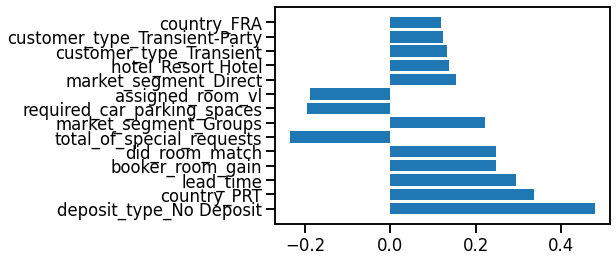

In [0]:
sortedCorr = correlaciones.sort_values('Abs(Cor)', ascending= False)[1:15]
corr = sortedCorr.Atributo
vals = sortedCorr.Correlacion
y_pos = np.arange(len(vals))
plt.barh(y_pos, vals)
plt.yticks(y_pos, corr)
plt.show()


## e. Se encuentra balanceado el set

In [0]:
# Buscamos conocer que tan balanceado está nuestro dataset
bookings_df['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [0]:
df_correlations['is_canceled'].value_counts(normalize=True)

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

## g. Implementación Árbol de decisión

In [0]:
df_correlations.head()

,lead_time,stays_in_week_nights,stays_in_weekend_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,assigned_room_vl,requested_room_vl,hotel_Resort Hotel,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,meal_BB,meal_FB,meal_HB,meal_SC,is_repeated_guest_0,is_repeated_guest_1,deposit_type_No Deposit,deposit_type_Non Refund,customer_type_Contract,...,country_CN,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ISR,country_ITA,country_NLD,country_NOR,country_POL,country_PRT,country_RUS,country_SWE,country_USA,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,did_room_match,booker_room_gain,is_canceled
0,342,0,0,2,0.0,0,0,0,0,0.0,0,0,3,3,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,737,0,0,2,0.0,0,0,0,0,0.0,0,0,3,3,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,7,1,0,1,0.0,0,0,0,0,75.0,0,0,3,1,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0
3,13,1,0,1,0.0,0,0,0,0,75.0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,14,2,0,2,0.0,0,0,0,0,98.0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [0]:
#Con sklearn podemos dividir nuestros datos en conjuntos de entrenamiento, validación y prueba.
# Para el análisis deberiamos utilizar un DF con las variables dummies cargadas
# Lo unico que tengo dudas es si en features no hay que dropear la columna 'is_canceled'
features =  df_correlations.loc[:, df_correlations.columns != 'is_canceled'].columns
target = 'is_canceled'

# Armamos 2 sets de datos
x_train, x_test, y_train, y_test = train_test_split(
    df_correlations[features].values, 
    df_correlations[target].values, 
    test_size=0.2, 
    random_state=42,
    stratify=df_correlations[target].values
)                           
# DIVIDO ENTRE TRAIN (0.8) Y TEST (0.2)

n_seeds = 50
accs = []
precisions = []
recalls = []
f1s = []

for seed in range(n_seeds):
  # Arbol de decisión
  arbol_sklearn = DecisionTreeClassifier(
      criterion='entropy',
      max_depth=5,
      min_samples_leaf=10, 
      ccp_alpha=0.01
  )
  # División train-validation (requiere x_train y y_train previos)
  x_train_, x_val_, y_train_, y_val_ = train_test_split(
      x_train, 
      y_train, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_train
  )                                           
  # DIVIDO ENTRE TRAIN-train_ (0.64), TRAIN-val_ (0.16), TEST (0.04), Y VAL (0.16)

  # Entrenamos al arbol
  arbol_sklearn.fit(x_train_,y_train_)

  # Ejecutamos nuestra predicción
  y_pred_val = arbol_sklearn.predict(x_val_)

  # Medimos (accuracy, precision, recall y f1Score) de nuestra predicción
  #accs.append(accuracy_score(y_val_,y_pred_val))
  precisions.append(precision_score(y_val_,y_pred_val))
  recalls.append(recall_score(y_val_,y_pred_val))
  #f1s.append(f1_score(y_val_,y_pred_val))

all_metrics = accs + precisions + recalls + f1s
metric_labels = ['Accuracy']*len(accs) + ['Precision']*len(precisions) + ['Recall']*len(recalls) + ['F1 Score']*len(f1s)


In [0]:
print(len(precisions))
print(len(recalls))

50
50


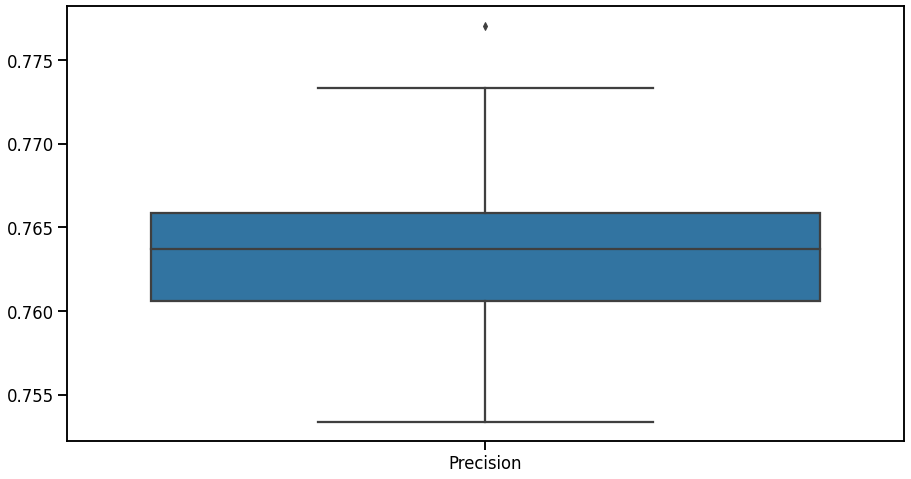

In [0]:
# Precision
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(['Precision']*len(precisions),precisions)

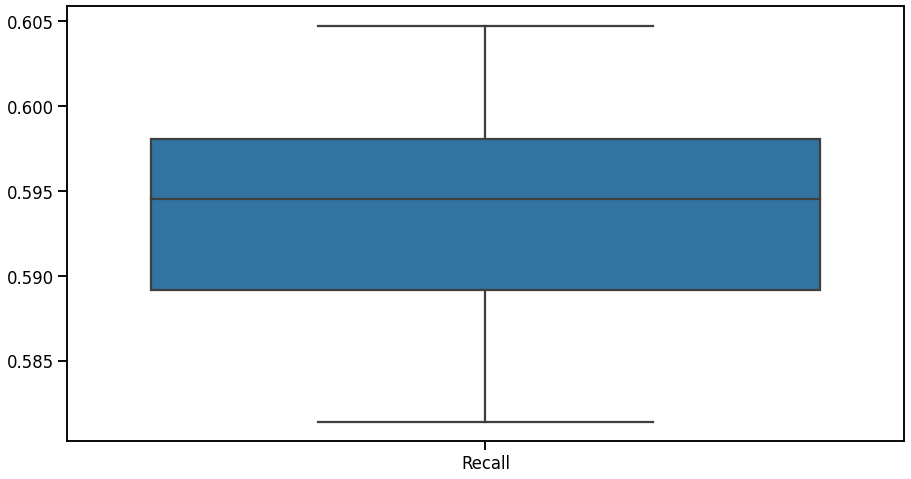

In [0]:
# Recall
sns.set_context('talk')
plt.figure(figsize=(15,8))
sns.boxplot(['Recall']*len(recalls),recalls)

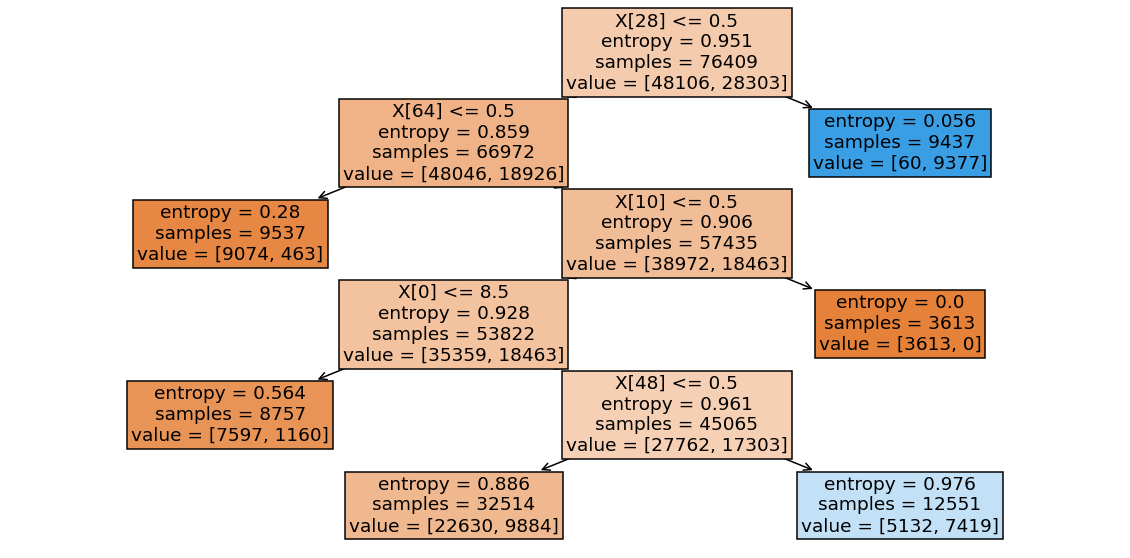

In [0]:
# GRÁFICA DEL ÁRBOL
plt.figure(figsize=(20,10))
plot_tree(arbol_sklearn,filled=True);

## g. Cross Validation

In [0]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

top_range = len(df_correlations.columns)
params_grid = {'criterion':['gini','entropy'],
               'max_depth':list(range(1,top_range))}

kfoldcv = StratifiedKFold(n_splits=5)
base_tree = DecisionTreeClassifier()
scorer_fn = make_scorer(fbeta_score, beta=2)
randomcv = RandomizedSearchCV(
    estimator=base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 50,
    random_state = 50
)
randomcv.fit(x_train,y_train);

In [0]:
# Guardamos los resultados de K-Fold 
kfold_results = pd.DataFrame(randomcv.cv_results_)
print(len(kfold_results))
kfold_results.head()

50


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.623854,0.017567,0.013430,0.000052,13,gini,"{'max_depth': 13, 'criterion': 'gini'}",0.769077,0.782876,0.776994,0.758803,0.771774,0.771905,0.008074,40
1,0.705589,0.017036,0.013811,0.000079,16,entropy,"{'max_depth': 16, 'criterion': 'entropy'}",0.753162,0.784860,0.762169,0.781237,0.774947,0.771275,0.011902,41
2,0.725023,0.019554,0.014135,0.000228,17,gini,"{'max_depth': 17, 'criterion': 'gini'}",0.763716,0.790012,0.783279,0.787429,0.784962,0.781880,0.009363,37
3,0.849522,0.009037,0.014890,0.000178,28,entropy,"{'max_depth': 28, 'criterion': 'entropy'}",0.781825,0.795985,0.793579,0.783100,0.783722,0.787642,0.005911,31
4,0.869252,0.021040,0.016045,0.001056,51,gini,"{'max_depth': 51, 'criterion': 'gini'}",0.785674,0.799854,0.791841,0.796819,0.789451,0.792728,0.005075,10


In [0]:
kfold_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.623854,0.017567,0.013430,0.000052,13,gini,"{'max_depth': 13, 'criterion': 'gini'}",0.769077,0.782876,0.776994,0.758803,0.771774,0.771905,0.008074,40
1,0.705589,0.017036,0.013811,0.000079,16,entropy,"{'max_depth': 16, 'criterion': 'entropy'}",0.753162,0.784860,0.762169,0.781237,0.774947,0.771275,0.011902,41
2,0.725023,0.019554,0.014135,0.000228,17,gini,"{'max_depth': 17, 'criterion': 'gini'}",0.763716,0.790012,0.783279,0.787429,0.784962,0.781880,0.009363,37
3,0.849522,0.009037,0.014890,0.000178,28,entropy,"{'max_depth': 28, 'criterion': 'entropy'}",0.781825,0.795985,0.793579,0.783100,0.783722,0.787642,0.005911,31
4,0.869252,0.021040,0.016045,0.001056,51,gini,"{'max_depth': 51, 'criterion': 'gini'}",0.785674,0.799854,0.791841,0.796819,0.789451,0.792728,0.005075,10
5,0.687750,0.017576,0.013713,0.000137,15,entropy,"{'max_depth': 15, 'criterion': 'entropy'}",0.766154,0.776713,0.772986,0.760810,0.779392,0.771211,0.006843,42
6,0.943653,0.015963,0.015571,0.000241,53,entropy,"{'max_depth': 53, 'criterion': 'entropy'}",0.780698,0.801253,0.799775,0.790009,0.790158,0.792379,0.007489,17
7,0.868297,0.011850,0.015395,0.000146,35,gini,"{'max_depth': 35, 'criterion': 'gini'}",0.782680,0.804197,0.794616,0.794081,0.786865,0.792488,0.007375,13
8,0.902885,0.014665,0.015400,0.000094,63,entropy,"{'max_depth': 63, 'criterion': 'entropy'}",0.781117,0.800203,0.800333,0.789132,0.791162,0.792389,0.007257,16
9,0.795338,0.019705,0.014896,0.000317,22,gini,"{'max_depth': 22, 'criterion': 'gini'}",0.780660,0.802119,0.785444,0.787174,0.782190,0.787517,0.007655,32


In [0]:
randomcv.best_params_

{'criterion': 'gini', 'max_depth': 39}

Corrimos nuestro análisis de K-Fold, para optimizar hiperparámetros utilizando dos criterios de scoring y obteniendo los siguientes resultados:


*   recall scorer: 
```
{
  criterion: gini,
  max_depth: 29
}
```

*   fbeta2 scorer:
```
{
  criterion: entropy,
  max_depth: 28
}
```



## h. Graficar Best Tree


[Text(677.6759836343192, 536.8050000000001, 'deposit_type_Non Refund <= 0.5\ngini = 0.466\nsamples = 95512\nvalue = [60133, 35379]'),
 Text(239.94668806092298, 523.215, 'did_room_match <= 0.5\ngini = 0.406\nsamples = 83795\nvalue = [60060, 23735]'),
 Text(39.41858503573638, 509.625, 'country_PRT <= 0.5\ngini = 0.094\nsamples = 11858\nvalue = [11274, 584]'),
 Text(11.135872639402098, 496.035, 'market_segment_Online TA <= 0.5\ngini = 0.041\nsamples = 7024\nvalue = [6878, 146]'),
 Text(6.029887456069052, 482.44500000000005, 'previous_cancellations <= 0.5\ngini = 0.014\nsamples = 3937\nvalue = [3909, 28]'),
 Text(5.098491792190524, 468.855, 'market_segment_Corporate <= 0.5\ngini = 0.013\nsamples = 3931\nvalue = [3905, 26]'),
 Text(3.845670507802367, 455.26500000000004, 'previous_bookings_not_canceled <= 3.5\ngini = 0.009\nsamples = 3679\nvalue = [3663, 16]'),
 Text(2.8725776729904173, 441.675, 'market_segment_Direct <= 0.5\ngini = 0.008\nsamples = 3670\nvalue = [3655, 15]'),
 Text(1.707916

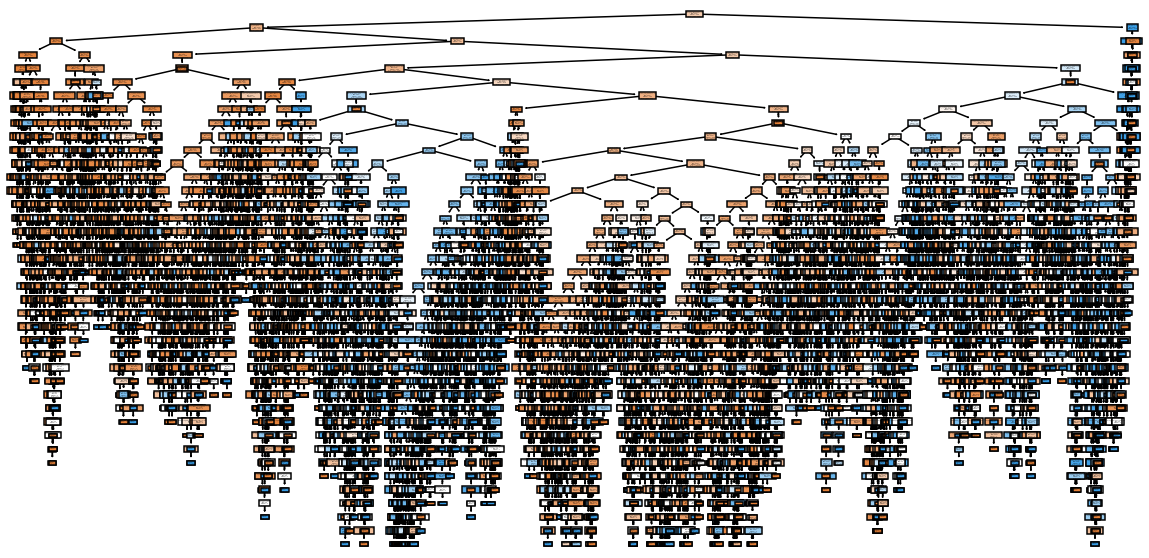

In [0]:
import matplotlib.pyplot as plt

best_tree = randomcv.best_estimator_
best_tree.fit(x_train,y_train)
plt.figure(figsize=(20,10))
plot_tree(
    best_tree,
    feature_names=df_correlations.columns,
    filled=True
)

In [0]:
# Podemos pedir el árbol correspondiente ya entrenado y ver cuán importante es cada atributo
best_tree = randomcv.best_estimator_

feat_imps = best_tree.feature_importances_
feat_imps

array([1.40437369e-01, 3.96139108e-02, 2.44135065e-02, 1.26197054e-02,
       6.24813919e-03, 5.89811766e-04, 1.73666139e-02, 4.61781810e-03,
       1.91325692e-03, 1.08272295e-01, 2.62333918e-02, 5.39054940e-02,
       9.77715710e-03, 9.00915343e-03, 9.69407962e-03, 3.60822284e-04,
       1.72830124e-03, 4.82195490e-03, 2.30144556e-03, 2.82170763e-03,
       6.09716500e-02, 5.51545068e-03, 3.76837927e-04, 4.37765168e-03,
       4.45860050e-03, 1.01927197e-03, 2.65168144e-04, 1.51806876e-04,
       2.37771926e-01, 6.03417566e-04, 1.18867341e-02, 6.57422555e-03,
       1.22909598e-03, 2.37115710e-03, 2.27261469e-03, 1.86501527e-03,
       2.06111576e-03, 1.25210667e-03, 5.30250365e-03, 3.14253299e-03,
       4.80401188e-03, 4.61679084e-03, 2.21730654e-03, 6.84143095e-04,
       3.83016404e-03, 2.39594665e-03, 8.43280877e-04, 1.17568997e-03,
       4.17305155e-02, 1.06375028e-03, 1.19302927e-03, 2.01390582e-03,
       5.61318156e-03, 7.80360411e-03, 4.07158305e-03, 5.11128669e-03,
      

In [0]:
# Vemos a que variables corresponden los atributos mas importantes
for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

deposit_type_No Deposit: 0.000151806875994012
is_repeated_guest_1: 0.0002651681437532674
market_segment_Complementary: 0.00036082228432289965
meal_FB: 0.0003768379274266417
babies: 0.0005898117660743831
customer_type_Contract: 0.0006034175664484043
country_ISR: 0.000684143094767049
country_NOR: 0.0008432808774135661
is_repeated_guest_0: 0.00101927196753692
country_RUS: 0.0010637502758169463
country_POL: 0.001175689968416915
country_SWE: 0.001193029269724625
country_AUT: 0.0012290959788452188
country_CN: 0.0012521066729408612
booker_room_gain: 0.0013995888660564286
market_segment_Corporate: 0.001728301240493707
country_CHE: 0.001865015267705898
days_in_waiting_list: 0.001913256921722007
country_USA: 0.0020139058154414395
country_CHN: 0.0020611157647048425
country_IRL: 0.00221730653936788
country_BRA: 0.0022726146944369537
market_segment_Groups: 0.0023014455647705056
country_BEL: 0.0023711571035753684
country_NLD: 0.0023959466532407995
market_segment_Offline TA/TO: 0.0028217076320155433


## Analizamos metricas K-Fold


In [0]:
from sklearn.metrics import confusion_matrix, classification_report

best_model = randomcv.best_estimator_
y_pred = best_model.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15033
           1       0.79      0.80      0.80      8845

    accuracy                           0.85     23878
   macro avg       0.84      0.84      0.84     23878
weighted avg       0.85      0.85      0.85     23878



Text(19.5, 0.5, 'True')

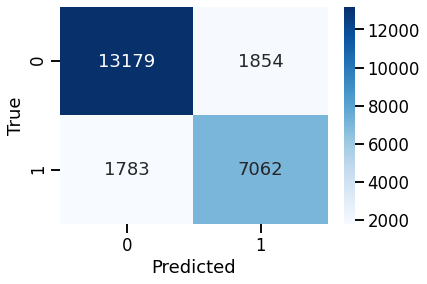

In [0]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:330: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


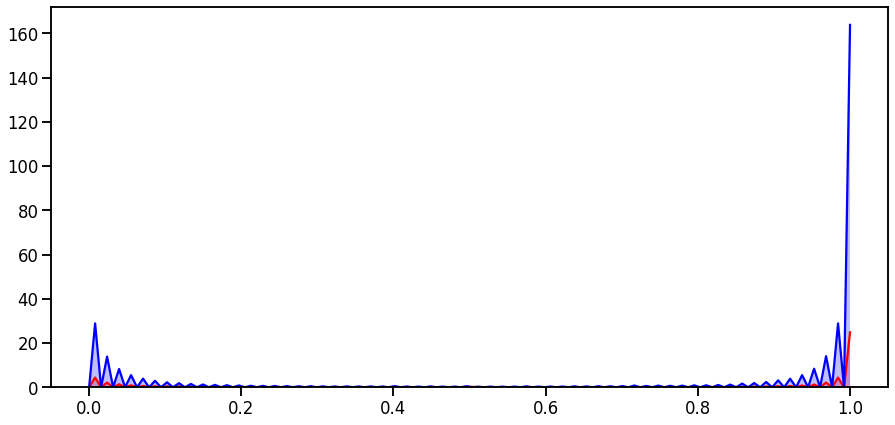

In [0]:
y_scores = best_model.predict_proba(x_test)
out_probs = y_scores[:,1]

plt.figure(figsize=(15,7))
sns.kdeplot(out_probs[y_test==0],shade=True,c='r')
sns.kdeplot(out_probs[y_test==1],shade=True,c='b')

## g. Poda de Arbol

In [0]:
# Vamos a podar nuestra arbol mejor clasificado
clf = randomcv.best_estimator_
path = clf.cost_complexity_pruning_path(x_train,y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [0]:
ccp_alphas


array([0.        , 0.        , 0.        , ..., 0.01812787, 0.01831502,
       0.10866758])

In [0]:
impurities

array([0.00930319, 0.00930319, 0.00930319, ..., 0.28448736, 0.35774746,
       0.46641504])

Text(0, 0.5, 'total impurity of leaves')

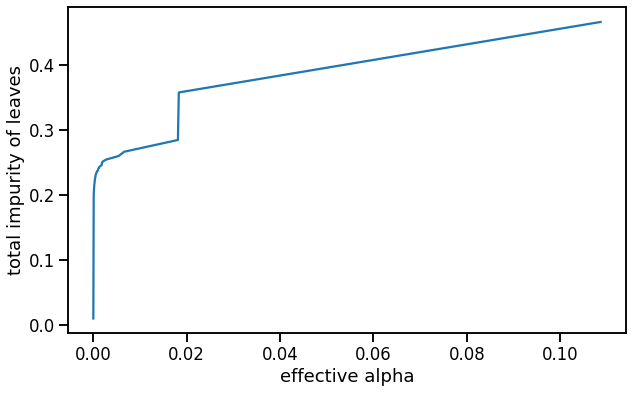

In [0]:
# Graficamos el cost complexity pruning path de nuestro arbol
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [0]:
filter_arr = []

# go through each element in arr
for element in impurities:
  # if the element is completely divisble by 2, set the value to True, otherwise False
  if element > 0.24:
    filter_arr.append(True)
  else:
    filter_arr.append(False)


filtered = ccp_alphas[filter_arr]
print(len(filtered))

14


## i. Alpha K-Fold Validation 

In [0]:
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import numpy as np

params_grid = {'ccp_alpha':filtered}

kfoldcv = StratifiedKFold(n_splits=10)
base_tree = DecisionTreeClassifier(
    random_state=0, 
    criterion = 'entropy',
    max_depth = 28 
)
scorer_fn = make_scorer(fbeta_score, beta=2)
randomcv = RandomizedSearchCV(
    estimator = base_tree,
    param_distributions = params_grid,
    scoring=scorer_fn,
    cv=kfoldcv,
    n_iter = 10,
    random_state = 50
)
randomcv.fit(x_train,y_train);

In [0]:
# Guardamos los resultados de K-Fold 
prune_kfold = pd.DataFrame(randomcv.cv_results_)
print(len(prune_kfold))
prune_kfold

10


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.240388,0.015923,0.006755,0.000112,0.018315,{'ccp_alpha': 0.018315023990871926},0.774068,0.766059,0.778528,0.775358,0.774683,0.781658,0.766397,0.778741,0.772102,0.784570,0.775216,0.005704,1
1,1.234455,0.018214,0.006761,0.000144,0.0066154,{'ccp_alpha': 0.0066154043863585615},0.774068,0.766059,0.778528,0.775358,0.774683,0.781658,0.766397,0.778741,0.772102,0.784570,0.775216,0.005704,1
2,1.260067,0.024903,0.006806,0.000104,0.00542059,{'ccp_alpha': 0.005420585620468585},0.774068,0.766059,0.778528,0.775358,0.774683,0.781658,0.766397,0.778741,0.772102,0.784570,0.775216,0.005704,1
3,1.253161,0.006653,0.006858,0.000177,0.00146567,{'ccp_alpha': 0.0014656697042258887},0.772801,0.724592,0.777057,0.717153,0.747241,0.739271,0.689858,0.713457,0.769729,0.772344,0.742350,0.028905,5
4,1.242069,0.023379,0.006795,0.000133,0.00121746,{'ccp_alpha': 0.0012174582100064474},0.729660,0.726565,0.727473,0.739949,0.738630,0.740986,0.717980,0.729780,0.732172,0.724911,0.730810,0.006936,6
5,1.234883,0.024768,0.006734,0.000105,0.00209293,{'ccp_alpha': 0.002092927966462592},0.697335,0.695711,0.701369,0.702063,0.707498,0.711039,0.688614,0.698585,0.702057,0.698396,0.700267,0.005894,10
6,1.218990,0.016125,0.006716,0.000100,0.00275969,{'ccp_alpha': 0.002759690931199786},0.773484,0.764650,0.778966,0.776103,0.773773,0.783411,0.767422,0.699305,0.771293,0.784215,0.767262,0.023422,4
7,1.230827,0.017612,0.006801,0.000282,0.00181693,{'ccp_alpha': 0.0018169274904004107},0.711052,0.711967,0.714286,0.717153,0.723407,0.725191,0.704475,0.713457,0.716068,0.711167,0.714822,0.005772,7
8,1.254244,0.009580,0.006748,0.000122,0.00184403,{'ccp_alpha': 0.001844032657149039},0.711052,0.711967,0.714286,0.702063,0.723407,0.725191,0.688178,0.713457,0.716068,0.711167,0.711683,0.009974,9
9,1.258240,0.009360,0.007014,0.000798,0.00180023,{'ccp_alpha': 0.0018002286773838583},0.711052,0.711967,0.714286,0.717153,0.723407,0.725191,0.704475,0.713457,0.716068,0.711167,0.714822,0.005772,7


In [0]:
for clf in :


SyntaxError: ignored

In [0]:
randomcv.best_params_

In [0]:
filtered

In [0]:
# Vamos a buscar el valor óptimo de alpha para nuestro arbol
clfs = []

for ccp_alpha in filtered:
    clf = DecisionTreeClassifier(
        random_state=0, 
        ccp_alpha=ccp_alpha,
        criterion = 'entropy',
        max_depth = 28
    )
    clf.fit(x_train, y_train)
    clfs.append(clf)

In [0]:
# Graficamos la relación entre alpha y la profundidad de nuestro arbol

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(filtered[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

In [0]:
# Graficamos el alpha que mejora nuestro fbeta score
from sklearn.metrics import fbeta_score

fbeta2_scores = [fbeta_score(y_test, clf.predict(x_test), beta=2) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(filtered[:-1], fbeta2_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("FBeta2 scores")

##j. Comparar alpha y arbol sin poda

Armar dos arboles con alpha distintos (apha elegido y alpha 0), entrenarlos y comparar la validacion


In [0]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(
      x_train, 
      y_train, 
      test_size=0.2, 
      random_state=seed,
      stratify=y_train
)

